# Aesthetics exploration based on wiki data

### Links:

* [Our website](https://antekskrobisz.wixsite.com/my-site-1)
* [Aesthetics Fandom](https://aesthetics.fandom.com/wiki/Aesthetics_Wiki)
* [Dataset](xxx)


## 1. Motivation

### 1.1. The dataset

We've found a Fandom page dedicated to aesthetics (see the link above), which describes more than 549 different aesthetics! We scraped a list of them from the website and downloaded all the descriptions with an intention and hope to draw some interesting insights into this fascinating topic.

Aesethetics are represented as nodes of our network. For each node we have a raw file with the Wiki description, as well as a clean file with the content of the page.

### 1.2. Why?

During the first session on this project we were trying to find something that we all are interested in. After searching for interesting Wiki pages we ended up with two best opstions. One of them was a Fandom dedicated to food. Lovely topic, yet already explored thoroughly. The second option was aesthetics related Fandom. We loved the idea of exploring aesthetics dataset right away.

### 1.3. Our goal

Our goal was to explore the resulting network and draw some conclusions regarding relations between different aesthetics. It seems right to refer to aesthetics definitions here, which is "the formal study of art, especially in relation to the idea of beauty". 

This matter is undeniably present in everybody's life, even if it is not necessarily the object of one's continuous attention. It just seems very obvious to us to jugde whether we find something beautiful or not. However, we don't really spend time to understand different points of view of the beauty itself.

Thereby, we intend to delivere to our end user a comprehensible way of exploring aesthetics and relations between them, as well as provide some insight into this topic.

## 2. Getting ready for the analyses & Basic stats

### 2.1. Data preprocessing

First of all, we used Fandom API to download the page containing full list of aesthetics. Then using regular expressions we extracted all the aesthetics names. We noticed, that some of them contain alternative names, therefore we used **split** to overcome this issue. We also noticed some inaccuracies between the names in the list of aesthetics and the names of their pages, so we relabeled relevant nodes.

The working code is presented below:

But first, imports (including those for analyses) :)

In [1]:
import urllib.request
import json
import re
import nltk
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from nltk.book import FreqDist
import os
import re
import community.community_louvain as community_louvain
import math
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from matplotlib import pyplot as plt
import requests
import scipy.stats as stats
import powerlaw
import os
from fa2 import ForceAtlas2
from nltk.tokenize import WordPunctTokenizer
import jaal
from dash import html
from bokeh.io import output_file, show
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool, WheelZoomTool, PanTool, TapTool , MultiLine, NodesAndLinkedEdges, EdgesAndLinkedNodes)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

%matplotlib inline  

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


/Users/antoniskrobisz/opt/anaconda3/lib/python3.8/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Now it's time to extract the list of aesthetics with relevant regex

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
title = "List_of_Aesthetics"
content = "prop=revisions&rvprop=content&rvslots=*" 
dataformat = "format=json" 

query = baseurl+action+"&"+content+"&titles="+title+"&"+dataformat
response = urllib.request.urlopen(query)
data = response.read()
cont = data.decode('utf-8')
jsontext = json.loads(cont)

en_pag=re.findall(r'\d+',str(jsontext['query']['pages'].keys()))
txt_new=jsontext['query']['pages'][str(en_pag[0])]['revisions'][0]['slots']['main']['*']

pattern="(?:\[\[(.*?)\]\])"
alph_txt=re.split('(?:\=\=A\=\=)', txt_new)
alph_list=re.findall(pattern, alph_txt[1])

In [ ]:
DG = nx.DiGraph()

for i in alph_list:
    if "|" in i:
        spl=re.split('(?:\|)', i)
        alph_list[alph_list.index(i)]=spl[1]
        DG.add_node(spl[1])    
    else:
        DG.add_node(i)

Below, we use a mapping for aesthetics scraped from a list that didn't match their site name.

In [ ]:
mapping = {'Neo - Romanism':'Neo-Romanism', 'Robotics Kid':'Robotics Kids', 'Sad people':'Sadpeople', 
           'Arts and Crafts':'Arts and Crafts Movement','Junkpunk':'Salvagepunk','Natural Philosophy':'Green_Academia',
          'Spy fiction':'Spy_Fiction','Shā mǎ tè':'Shamate','Woodland Goth':'Woodland_goth','Ms Paint':'MS Paint'}
DG = nx.relabel_nodes(DG, mapping)

Let's save the list for later use

In [ ]:
pd.DataFrame(list(DG.nodes())).to_csv('aesthetics.csv')

Downloading a raw document for each of the aesthetics.

In [ ]:
for char in DG:
    address = 'https://aesthetics.fandom.com/api.php?'
    action="action=query"
    titles=f"titles={char}"
    content="prop=revisions&rvslots=*&rvprop=content"
    dataformat="format=json"
    query = '%s%s&%s&%s&%s' % (address, action, titles, content, dataformat)
    response = requests.get(query)
    content_char = response.text
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'w') as f:
        f.write(content_char)

Let's add the connections to our network we used this regex to do so:
 - ````(?<=\[\[).*?(?=\]\])```` 
     - ````(?<=\[\[)```` - positive lookbehind of double squared brackets (looks for '\[\[' but does not include it in the match)
     - ````.*?```` - matches any character any number of times but as few times as possible
     - ````(?=\]\])```` - positive lookahead of double squared brackets (looks for '\]\]' but does not include it in the match)

In [ ]:
for char in DG:
    char_file = char.replace('/','_')
    with open('aesthetics/'+f'{char_file}.txt', 'r') as f:
        a = f.read().replace('\n', '')
        pol = list(set(re.findall(r'\[\[([\w\s]*).*?\]\]', a)))
    table = str(re.findall(r'(?<=\{\{).*?(?=\}\})', a))

    
    connections = [x for x in list(set(re.findall(r'(?<=\[\[).*?(?=\]\])', table))) if x in DG]
    
    for c in connections:
        DG.add_edge(char, c )

The code below downloads the clean verion of the descriptions:

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()

for file in DG:
    
    if file == "Mindcore":
        print(" ")
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.sub('=+.*?=+','',re.sub('=+ Gallery.*','', re.sub('\t','',re.sub('\n','', clean))))

        ftk = tk.tokenize(clean.lower())

        ftk =[ tok for tok in ftk if tok.isalpha()]
        if file == "Coffee House/Cafe":
            char_file='Coffee House_Cafe'
        with open('clean/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(' '.join([str(item) for item in ftk]))
    

This one downloads and tokenizes the descriptions:

In [ ]:
#without stopwords
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords

baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()

for file in DG:
    
    if file == "Mindcore":
        print(" ")
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.sub('=+.*?=+','',re.sub('=+ Gallery.*','', re.sub('\t','',re.sub('\n','', clean))))

        ftk = tk.tokenize(clean.lower())

        ftk =[ tok for tok in ftk if tok.isalpha()]

        ftk = [tok for tok in ftk if not tok in stopwords.words()]

        with open('cleaner/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(' '.join([str(item) for item in ftk]))
    

And finally the code that downloads just the first part od the description, that well then use for text summarization:

In [ ]:
baseurl = "https://aesthetics.fandom.com/api.php?"
action = "action=query"
content = "prop=extracts&exlimit=1&explaintext"
dataformat ="format=json"
tk = WordPunctTokenizer()
check=['Junkpunk', 'Natural Philosophy', 'Shā mǎ tè', 'Spy fiction', 'Woodland Goth']
for file in DG:
    if file == "Mindcore":
        continue
    elif file in check:
        if file == 'Junkpunk':
            file='Salvagepunk'
        if file == 'Natural Philosophy':
            file='Green_Academia'
        if file == 'Spy fiction':
            file='Spy_Fiction'
        if file == 'Shā mǎ tè':
            file='Shamate'
        if file == 'Woodland Goth':
            file='Woodland_goth'
    else:
        char_file = file.replace('/','_')
        title = "titles="+urllib.parse.quote_plus(file)
        query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
        wikiresponse = urllib.request.urlopen(query)
        wikidata = wikiresponse.read()
        wikitext = wikidata.decode('utf-8')

        pag_val=re.findall(r'\d+',str(json.loads(wikitext)['query']['pages'].keys()))

        clean = json.loads(wikitext)['query']['pages'][pag_val[0]]['extract']
        clean = re.split('=+.*?=+',clean)
        clean = [re.sub('\n','', i) for i in clean[0]]


        clean = ''.join(map(str, clean))
        with open('text_analysis/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(clean)

### 2.2. Basic stats

## 3. Tools, theory and analysis 

# 3.1. Graph analysis

In [64]:
UG = DG.to_undirected()

In [87]:
partition = community_louvain.best_partition(UG)
len(set(partition.values()))

40

In [88]:
community_louvain.modularity(partition, UG)

0.4856112664949235

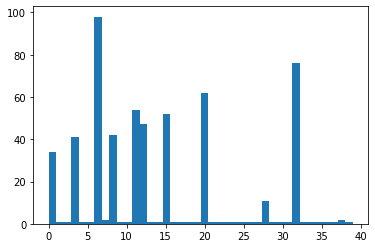

In [89]:
plt.hist(partition.values(), len(set(partition.values())))
plt.show()

# 3.2. Text analysis and WordClouds

## Text analysis

The aim here is to understand the definition of aesthetics better, and what is our data about.

First, we read the aesthetics list:

In [2]:
df_aesthetics = pd.read_csv('aesthetics.csv')

In [ ]:
file_list=[]

for aest in list(df_aesthetics['0']):
    aest_file = aest.replace('/','_')
    file_list+=[aest_file+".txt"]

In [ ]:
corpus_root = os.getcwd()+'/clean'

wordlists = PlaintextCorpusReader(corpus_root, file_list)

wholeText = nltk.Text(wordlists.words())

In [193]:
print("The total number of words in the corpus is {:d}, including {:d} different words. Lexical diverity is equal to {:2f}".format(len(wholeText), len(set(wholeText)), len(set(wholeText)) / len(wholeText)))

The total number of words in the corpus is 212748, including 26533 different words. Lexical diverity is equal to 0.124716


In [72]:
fdist1 = FreqDist(wholeText)
fdist1

FreqDist({'the': 10224, 'and': 7952, 'of': 6456, 'to': 4227, 'a': 4180, 'in': 3523, 'is': 3123, 'as': 2414, 'by': 2262, 'with': 2086, ...})

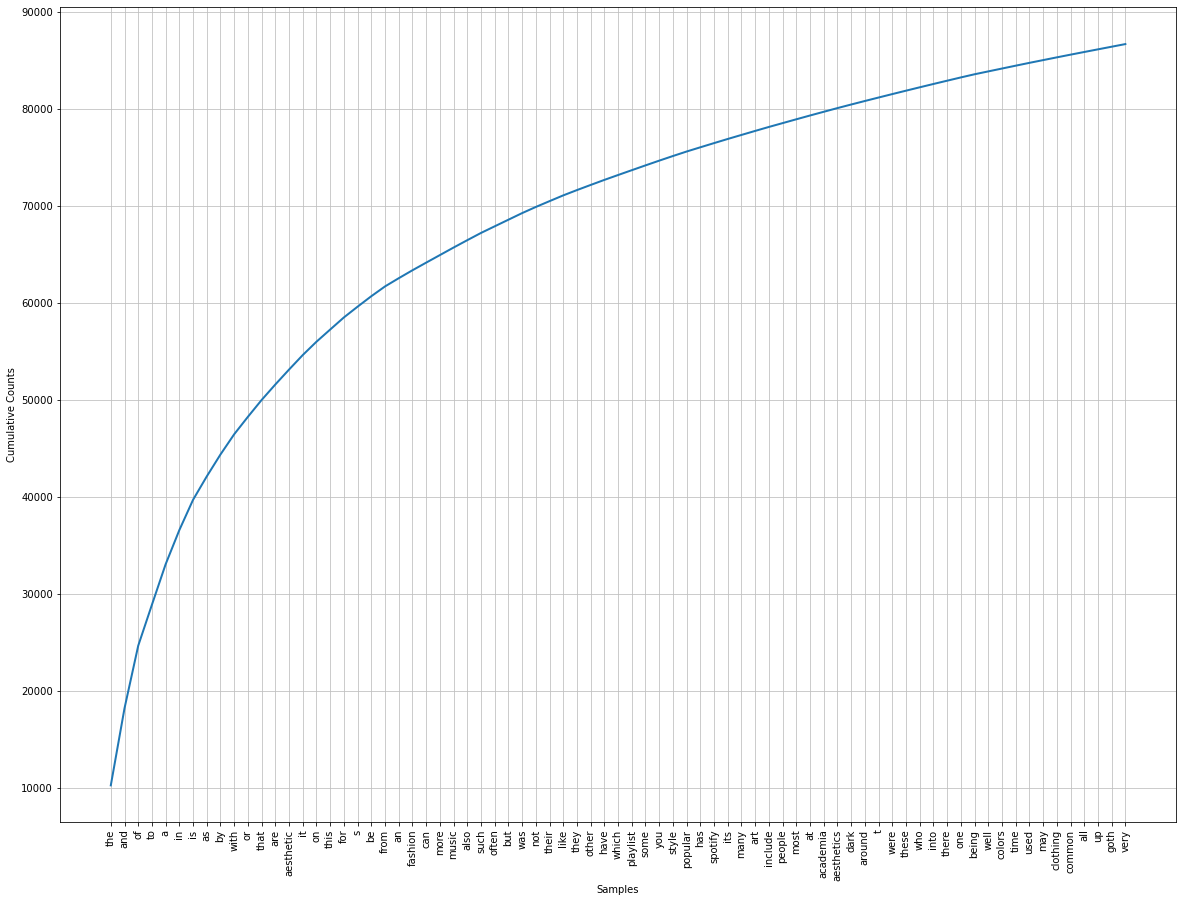

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [73]:
plt.figure(figsize=(20, 15))
fdist1.plot(75, cumulative=True)

Not so informative, because of the massive amount of stopwords, lest use the tokenized text!

In [42]:
corpus_root = os.getcwd()+'/cleaner'

wordlists_nostop = PlaintextCorpusReader(corpus_root, file_list)

nostopText = nltk.Text(wordlists_nostop.words())

In [194]:
print("The total number of words in the tokenized corpus is {:d}, including {:d} different words. Lexical diverity in this case is equal to {:2f}".format(len(nostopText), len(set(nostopText)), len(set(nostopText)) / len(nostopText)))

The total number of words in the tokenized corpus is 127637, including 26181 different words. Lexical diverity in this case is equal to 0.205121


Now, we try to understand the aesthetics by looking at dispersio plot of different words, that we've chosed arbitrarily.

In our case, in doesn't make sense to analyse at which places of the dispersion plot do the particular words occur. What does make sense, however is to look at the 'density' of occurrence of some words. 

In [53]:
fdist1 = FreqDist(wholeText)
fdist1

plt.figure(figsize=(20, 15))
fdist1.plot(75, cumulative=True)disp = ['aesthetic', 'fashion', 'music', 'style','art', 'people', 'colors']

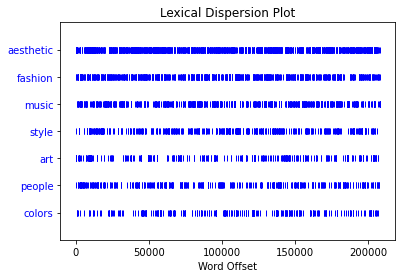

In [54]:
wholeText.dispersion_plot(disp)

Nice attempt, but not necessairly the great insight. Let's try different approach.
Now, we'll look at the possible cagtegories of aesthetics.

In [55]:
disp2 = ['architecture', 'music', 'fashion', 'art', 'culture', 'nature']

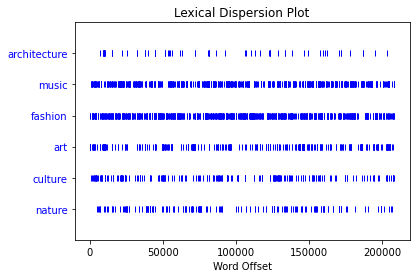

In [56]:
wholeText.dispersion_plot(disp2)

We wanted to examine what areas of beauty and art do the aesthetics refer to. It's clear that the vast majority are connected to fashion and music. Less of them, but still a lot, are concerned with art, culture and nature. And some of them reflect architecture.

In [57]:
wholeText.collocations()

spotify playlist; hip hop; better understanding; help get; centered
around; video games; jersey shore; dark academia; united states;
external links; revolves around; color palette; also known; hot topic;
femme fatale; new york; avant garde; tumblr com; vacation dadcore;
https www


Collocations are not very informative, but give us a hint that possibly a lot of aesthetics have related spotify playlist, and that there might be some noise in the data.

## WordClouds

Now, we will take a look at wordclouds for the 5 biggest communities.
In order to do so, we have to calculate the Term frequency–Inverse document frequency (TF-IDF) for each of the word within each community.

First, we create a corpus for each of the 5 biggest community. Then we create a dict containing corpora for all of them. Having done that, the TF for words for each community is computed using simple loops, and according to the equation below:

$ tf(t,d) = \frac{f{t,d}}{\sum_{t'∈d} f{t',d}} $

*where ft,d is the raw count of a term in a document, i.e., the number of times that term t occurs in document d.* 

Then IDF values for each word in the whole corpus were computed and put in the dict. We treated each community corpus as documents over which idf was calculated. We used the following idf equation:

$ idf(t,D) = \frac{N}{n{t}} $

*where N is the total number of documents in the corpus and nt is the number of documents where the term *t* appears.* 


TFIDF was then computed simply by multiplying the above values for each of the communities. 

In order to prepare the scores for computing wordclouds they were multiplied by 10000 and rounded to integers.

Having the scores values ready the strings for Wordcloud function were prepared accoring to the score numbers. 

In order to make the wordcloud more intresting and unique for each community the masks were applied, which were the pictures representing the most connected aesthetic of the community.

As expected, each of the communities has different words that represent them.

*Note, that each time that the code is run, the partitioning may be different, and community numbers might differ, therefore, if the code is rerun, the resulting wordclouds' masks might lose their sense. If you want to run the code yourself you should take that into consideration ;)*

In [90]:
sums = {}
coms = []
for x in set(partition.values()):
    sums[x] = sum(value == x for value in partition.values())
    coms.append([k for k,v in partition.items() if v == x])

In [91]:
big_coms = [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)][:5]

In [92]:
big_coms.sort()
big_coms

[6, 11, 15, 20, 32]

In [93]:
nx.set_node_attributes(UG, partition, "partition")

In [94]:
#Sorting the aesthetics by edges and communities
ch_1=[]
for n in UG.nodes():
    ch_1.append((n,UG.degree(n),UG.nodes()[n]['partition']))

ch_1.sort(key=lambda x:x[1],reverse=True)
ch_1.sort(key=lambda x:x[2])

In [95]:
ch_big = [x for x in ch_1 if x[2] in big_coms]

In [96]:
#Name each community by its three most connected characters.
count=0
com_name={}
for i in range(len(ch_big)):
    if count>=len(big_coms):
        break
    if ch_big[i][2]==big_coms[count]:
        com_name[big_coms[count]]=str(ch_big[i][0])+"-"+str(ch_big[i+1][0])+"-"+str(ch_big[i+2][0])
        count+=1
        continue

    

In [97]:
com_name

{6: 'Cottagecore-Vintage-Naturecore',
 11: 'Pastel-Kawaii-Softie',
 15: 'Punk-Goth-Grunge',
 20: 'Baddie-Boujee-Drugcore',
 32: 'Vaporwave-Milleniwave-Kidcore'}

Here is the moment of defining our masks. If you want to recreate this step of analysis take a look at the note in the description of this step of analysis.

In [155]:
imag = ['cottage','pastel','goth','baddie','vapor']

In [98]:
community_corpora={}

for com in [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)]:
    char = coms[com]
    
    char = [x.replace('/','_') for x in char]
    
    clist = [i+".txt" for i in char]
    
    wordlists_ = PlaintextCorpusReader(corpus_root, clist)
    community_corpora[com]= nltk.Text(wordlists_.words())

In [99]:
#TF values ft/len(text) and idf values log((N/nt)
comunity_tf={}
for x in big_coms:
    l=[]
    l = sorted(dict(FreqDist(community_corpora[x])).items(), key=lambda x: x[1], reverse=True)
    d={}
    for y in l:
        d[y[0]] = y[1]/len(community_corpora[x])
    comunity_tf[x] = d

In [100]:
for r in comunity_tf:
    print(sorted(comunity_tf[r].items(), key = lambda x: x[1], reverse = True)[:5])

[('aesthetic', 0.014698864178677102), ('fashion', 0.005535935859501765), ('often', 0.005010976424549012), ('cottagecore', 0.004629187744583373), ('like', 0.004438293404600554)]
[('aesthetic', 0.013993003498250875), ('lolita', 0.009638038123795245), ('fashion', 0.008781323623902335), ('playlist', 0.006853715999143285), ('style', 0.00642535874919683)]
[('goth', 0.014519572953736655), ('fashion', 0.011601423487544484), ('music', 0.009466192170818505), ('aesthetic', 0.008683274021352314), ('punk', 0.008327402135231317)]
[('aesthetic', 0.010828592968268111), ('often', 0.007881570831334384), ('fashion', 0.007470358440134329), ('music', 0.005208690288534028), ('like', 0.005140154890000685)]
[('aesthetic', 0.012670177879360032), ('music', 0.010434264135943555), ('vaporwave', 0.006856802146477194), ('playlist', 0.00675742820232535), ('spotify', 0.006111497565338369)]


In [101]:
N_com = len(community_corpora)

comunity_tfidf = comunity_tf.copy()
idf_com = {}

for word in set(nostopText):
    nt = 0
    for comu in community_corpora:
        if word in set(community_corpora[comu]):
            nt+=1
    idf_com[word] = math.log((N_com/(nt+1)),10)
    
for comu in comunity_tfidf:
    for word in comunity_tfidf[comu]:
        comunity_tfidf[comu][word] = int(comunity_tfidf[comu][word]*idf_com[word]*10000) # multiplying by 10000 and changing into integer to prepare the scores for wordclouds

In [102]:
for r in comunity_tfidf:
    print(sorted(comunity_tfidf[r].items(), key = lambda x: x[1], reverse = True)[:5])

[('cottagecore', 32), ('goblincore', 23), ('aesthetic', 22), ('nature', 16), ('playlist', 14)]
[('lolita', 79), ('kawaii', 53), ('playlist', 35), ('spotify', 33), ('unicorn', 26)]
[('goth', 94), ('punk', 50), ('metal', 30), ('bands', 29), ('goths', 28)]
[('jersey', 31), ('shore', 28), ('often', 20), ('mafia', 18), ('fashion', 17)]
[('vaporwave', 47), ('playlist', 35), ('spotify', 31), ('music', 29), ('synthwave', 28)]


In [157]:
wc_str = {}

for comu in big_coms:
    wc_str[comu] = ''

    for x in comunity_tfidf[comu]:
        if x not in ('spotify','playlist','aesthetics', 'aesthetic'):
            wc_str[comu] += (x+' ')*comunity_tfidf[comu][x]

In [ ]:
partition = community_louvain.best_partition(UG)
len(set(partition.values()))

community_louvain.modularity(partition, UG)

plt.hist(partition.values(), len(set(partition.values())))
plt.show()

sums = {}
coms = []
for x in set(partition.values()):
    sums[x] = sum(value == x for value in partition.values())
    coms.append([k for k,v in partition.items() if v == x])

big_coms = [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)][:5]

big_coms.sort()
big_coms

nx.set_node_attributes(UG, partition, "partition")

#Sorting the characters by edges and communities
ch_1=[]
for n in UG.nodes():
    ch_1.append((n,UG.degree(n),UG.nodes()[n]['partition']))

ch_1.sort(key=lambda x:x[1],reverse=True)
ch_1.sort(key=lambda x:x[2])

ch_big = [x for x in ch_1 if x[2] in big_coms]

#Name each community by its three most connected characters.
count=0
com_name={}
for i in range(len(ch_big)):
    if count>=len(big_coms):
        break
    if ch_big[i][2]==big_coms[count]:
        com_name[big_coms[count]]=str(ch_big[i][0])+"-"+str(ch_big[i+1][0])+"-"+str(ch_big[i+2][0])
        count+=1
        continue

    

com_name

imag = ['cottage','pastel','goth','baddie','vapor']

community_corpora={}

for com in [x[0] for x in sorted(sums.items(), key=lambda x: x[1], reverse=True)]:
    char = coms[com]
    
    char = [x.replace('/','_') for x in char]
    
    clist = [i+".txt" for i in char]
    
    wordlists_ = PlaintextCorpusReader(corpus_root, clist)
    community_corpora[com]= nltk.Text(wordlists_.words())

#TF values ft/len(text) and idf values log((N/nt)
comunity_tf={}
for x in big_coms:
    l=[]
    l = sorted(dict(FreqDist(community_corpora[x])).items(), key=lambda x: x[1], reverse=True)
    d={}
    for y in l:
        d[y[0]] = y[1]/len(community_corpora[x])
    comunity_tf[x] = d

for r in comunity_tf:
    print(sorted(comunity_tf[r].items(), key = lambda x: x[1], reverse = True)[:5])

N_com = len(community_corpora)

comunity_tfidf = comunity_tf.copy()
idf_com = {}

for word in set(nostopText):
    nt = 0
    for comu in community_corpora:
        if word in set(community_corpora[comu]):
            nt+=1
    idf_com[word] = math.log((N_com/(nt+1)),10)
    
for comu in comunity_tfidf:
    for word in comunity_tfidf[comu]:
        comunity_tfidf[comu][word] = int(comunity_tfidf[comu][word]*idf_com[word]*10000) # multiplying by 10000 and changing into integer to prepare the scores for wordclouds

for r in comunity_tfidf:
    print(sorted(comunity_tfidf[r].items(), key = lambda x: x[1], reverse = True)[:5])

wc_str = {}

for comu in big_coms:
    wc_str[comu] = ''

    for x in comunity_tfidf[comu]:
        if x not in ('spotify','playlist','aesthetics', 'aesthetic'):
            wc_str[comu] += (x+' ')*comunity_tfidf[comu][x]

In [154]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

<Figure size 432x288 with 0 Axes>

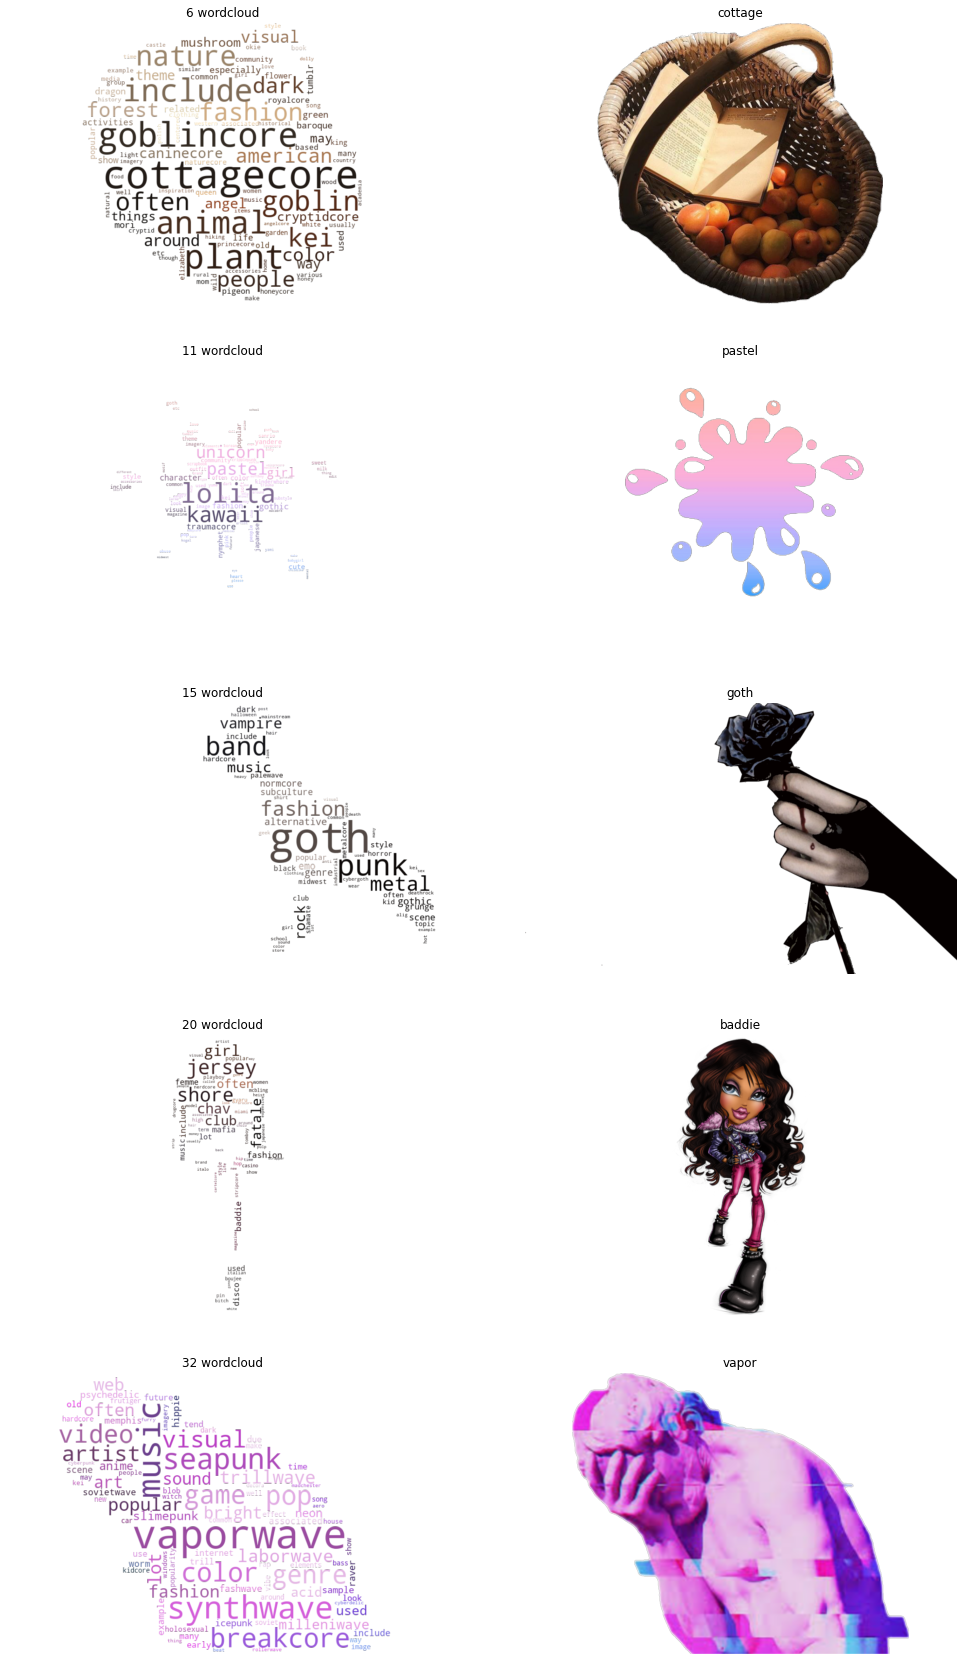

In [158]:
plt.figure()
stopwords = set(STOPWORDS)
plt.figure(figsize=[17, 30])

for t in range(len(big_coms)):
    plt.subplot(5, 2, 2*t+1).set_title(str(big_coms[t])+" wordcloud")
    
    mask = np.array(Image.open(imag[t]+".png"))
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            transformed_mask[i][j] = list(map(transform_format, mask[i][j]))
            
    image_colors = ImageColorGenerator(mask)
    
    wordcloud = WordCloud(max_font_size=130, collocations = False, width = 600, height = 600,
                mode = 'RGBA',
                background_color =None,
                stopwords = stopwords,
                mask = transformed_mask,
                min_font_size = 10).generate(wc_str[big_coms[t]])
    
    wordcloud.recolor(color_func=image_colors).to_file(imag[t]+'_cloud.png')
    
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.subplot(5, 2, 2*t+2).set_title(imag[t])
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
plt.show()

Let's try to make sense of the wordclouds!!!

**Cottagecore-Vintage-Naturecore**

The wordcloud clearly shows, that this community is related to nature (nature, forest, plant, animal etc.), royalty (queen, king, royalcore) and supernatural/fantasy world (angel, goblin)
Makes sense, isn't it? People have always looked for beauty within nature, which is also often connected with supernatural powers

**Pastel-Kawaii-Softie**

Aesthetics is complex enough that there can be apparent contradictions (cute and macabre; pink and goth; sweet and abuse). It seems to be only natural that seemingly opposite things can blend together when it comes to our understanding of beauty

**Punk-Goth-Grunge**

Let's get back to the question from our video: How close is goth to punk? Very close indeed! Both clothing and music seem important for this community, and surprisingly or not they are connected do mainstream somehow

**Baddie-Boujee-Drugcore**

Here we see quite a broad variety of words, undoubtedly connected to gender and supposedly and (re)defining femininity (girl, femme, woman, tomboy)

**Vaporwave-Milleniwave-Kidcore**

This one is clearly a 'younger' trend within aesthetics. Words such as "video", "internet" or "car" prove that.  It is also not surprising that it is strongly associated with visuality. Interesting. No?

Comment on the result:

The above wordclouds, generated for different communities, show us the abundance of means of expressions, as well as the fact that aesthetics develop at different times and are somewhat fluid, and interconnected

# 3.2. Advanced Text Analysis

In this section we are interested in analyzing different aspects of the text of each wiki page.

We are interested in generating a short and easy to read summary of the description of each aesthetic to display it in the visuals of the web page.

We are also interested in analyzing the the sentiment analysis of each aesthetic to determine the happiest and saddest. Additionally, we will perform these analysis into the communities generated in the previous sections.

Finally, we analyze the description symilarities to create a new network based on this and compare it with the original one.

### Description Summary

This section is dedicated to create a summary of the description of each aesthetics. 

We use a method uses a simple approach of splitting each file into sentences to measure the cosine distance between them. Once we have this, we generate a similarity matrix to convert each sentence into np vector. Later, we create a graph to use the page_rank algorithm to calculate the importance of each sentence and get the 2 most important sentences which are the ones that integrate the summary.

We followed the code and instructions in "Understand Text Summarization and create your own summarizer in python. An Introduction to Text Summarization" (Dubey, P., 2018).
It can be reviewed in https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

First, we create a function that loads the description of each aesthetic. We have the descriptions saved in .txt files 

In [101]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
 
def read_article(file_name):
    with open('text_analysis/'+f'{file_name}.txt', 'r',encoding="utf-8") as f:
        clean=f.read()
    article = clean.split(". ")
    sentences1 = []

    for sentence in article:
        sentences1.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences1.pop() 
    
    for i in sentences1:
        if i == ['']:
            sentences1.remove(i)
            
    sentences=sentences1.copy()
    
    return sentences

We generate a function that calculate the cosine distance of the sentences.

In [102]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

We create a function that takes the the vectors of the cosine distance and create a similarity matrix to assess the similarity between the sentences. 

In [103]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

We generate a function that calls the previous ones and get the top 2 highest ranked sentences to join them and generate the summary of the text.

In [104]:
def generate_summary(file_name, top_n=2):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph,max_iter=500000)
    
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)     
    
    if len(ranked_sentence) < top_n:
        top_n=len(ranked_sentence)
    
    for i in range(top_n):
        summarize_text.append(" ".join(ranked_sentence[i][1]))
    
    return summarize_text

We run the summarization functions into all the description files we have stored to generate the abstracts and save the results into new .txt files for further use.

In [105]:
for file in DG:
    char_file = file.replace('/','_')
    char_file = char_file.replace('/','_')
    if file =="Horror":
        continue
    else:   
        txt_sum=generate_summary(char_file,2)
        txt_sum_final=""
        delimiter=". "
        txt_sum_final=delimiter.join(txt_sum)

        with open('text_sum/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
            f.write(txt_sum_final)

The summarization method works for all description except for the "Horror" one. For this file, the cosine distance does not converge within the max iterations we set and generates an error.
To work around it, we adapt the method and run it again only with the file to successfully generate the abstract for the Horror aesthetic.

In [106]:
stop_words = stopwords.words('english')
char_file='Horror'
top_n=2
summarize_text = []
with open('text_analysis/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
    clean=f.read()
    article = clean.split(".")
    sentences = []

    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    
        
    for i in sentences:
        if i == ['']:
            sentences.remove(i)
            
sum_sentences=[]
sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
scores = nx.pagerank(sentence_similarity_graph,max_iter=600)
ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
sum_sentences.append(ranked_sentence[0][1])
sum_sentences.append(ranked_sentence[1][1])

summarize_text.append(" ".join(sum_sentences[0]))
summarize_text.append(" ".join(sum_sentences[1]))
        
txt_sum_final=""
delimiter=". "
txt_sum_final=delimiter.join(summarize_text)

with open('text_sum/'+f'{char_file}.txt', 'w',encoding="utf-8") as f:
    f.write(txt_sum_final)

The method works well for the mayority of the aesthetics, however, it has some issues with the aesthetics that has names with abreviations like J. P. or others that use a dot. This is because the sentence tokenizer uses the dot as a split token and the method interprets each letter as a separate sentece and not a name.

### Sentiment Analysis for each Aesthetic using LabMT and VADER

In this section we will analyze the sentiment analysis using the VADER and LabMT methods to find the happiness and saddness of each aesthetic and community.

We start by loading the correct libraries and methods.

In [107]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from operator import itemgetter, attrgetter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statistics
import matplotlib.pyplot as plt
import json

We load the labMT word list for later use.

In [108]:
#loading labMT as a df
df_lab = pd.read_csv('labMT.csv',sep=';')
df_lab

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1.0,8.50,0.9313,3600,--,--,1728
1,happiness,2.0,8.44,0.9723,1853,2458,--,1230
2,love,3.0,8.42,1.1082,25,317,328,23
3,happy,4.0,8.30,0.9949,65,1372,1313,375
4,laughed,5.0,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218.0,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219.0,1.48,0.9089,--,--,3192,--
10219,rape,10220.0,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221.0,1.30,0.8391,2124,4707,3319,2107


With the libraries and the word list loaded we proceed to calculate the VADER and LabMT score of each aesthetic and store it into a list for each method.

In [109]:
stop_words = list(set(stopwords.words('english')))
char_hap = []
char_vad=[]
lemmatizer = WordNetLemmatizer()

#loads the content of each aesthetic and splits it by sentences
for file in DG:
    char_file=file.replace('/','_')
    char_file=char_file.replace(' ','_')
    text_words = []
    with open('sentiment/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
        clean=f.read()
        sent_text = nltk.sent_tokenize(clean)
        tokenized_text = nltk.word_tokenize(clean)

        for i in tokenized_text:
            if i in stop_words or not i.isalpha():
                tokenized_text.remove(i)
            else:
                text_words.append(lemmatizer.lemmatize(i.lower()))

#Calculating the LabMT score for each aesthetic 
    sent_avg = 0 
    count = 0
    for i in text_words:
        try:            
            if i in df_lab.word.to_list():
                sent_avg+=float(df_lab.loc[df_lab['word']==i]['happiness_average'].to_string(index=False))
                count+=1
        except:
            continue
    if count != 0:
        sent_avg/=count
        char_hap.append((char_file,sent_avg))
    else:
        char_hap.append((char_file,0))

#Calculating the Vader score for each aesthetic 
    analyzer = SentimentIntensityAnalyzer()
    sent_comp = 0 
    count = 0
    for i in sent_text:
        try:
            vs = analyzer.polarity_scores(i)
            sent_comp+=vs['compound']
            count+=1
        except:
            continue
    if count != 0:
        sent_comp/=count
        char_vad.append((char_file,sent_comp))
    else:
        char_vad.append((char_file,0))

Once we have the scores we can sort the lists from highest to lowest or reverse them to get the top and bottom for each method.

In [110]:
char_vad2=sorted(char_vad, key=itemgetter(1),reverse=True)
happiest_char=char_vad2[0:10]

print("The 10 happiest aesthetics according to the VADER method are \n")
print(happiest_char)

The 10 happiest aesthetics according to the VADER method are 

[('Bunnycore', 0.906), ('Miami_Metro', 0.768), ('Lagenlook', 0.7191666666666667), ('Snowdrop', 0.6938749999999999), ('Romantic_Goth', 0.6900999999999999), ('Scrapbook', 0.6828714285714286), ('Ethereal', 0.6662250000000001), ('Nanopunk', 0.6649499999999999), ('Summer', 0.66422), ('Happycore', 0.6529166666666666)]


In [111]:
char_vad2=sorted(char_vad, key=itemgetter(1))
happiest_char=char_vad2[0:10]

print("The 10 saddest aesthetics according to the VADER method are \n")
print(happiest_char)

The 10 saddest aesthetics according to the VADER method are 

[('Nuclear', -0.5365333333333333), ('Cottagegore', -0.531075), ('Bastardcore', -0.51574), ('Horror', -0.48490333333333324), ('Yakuza', -0.4354), ('Hatecore', -0.41985), ('Yanki', -0.3938714285714286), ('Southern_Gothic', -0.39385000000000003), ('Anglo_Gothic', -0.3927714285714285), ('Postmodernism', -0.3902)]


In [112]:
char_hap2=sorted(char_hap, key=itemgetter(1),reverse=True)
happiest_char=char_hap2[0:10]

print("The 10 happiest aesthetics according to the LabMT method are \n")
print(happiest_char)

The 10 happiest aesthetics according to the LabMT method are 

[('Bookstore_Girl', 6.612), ('Glam_Girl', 6.411333333333334), ('Ukiyo-e', 6.369600000000002), ('Plant_Mom', 6.296349206349202), ('Lagenlook', 6.279545454545453), ('Spring', 6.257209302325583), ('Pixel_Cutie', 6.2496), ('Magenta', 6.2441666666666675), ('Romantic_Italian', 6.213731343283582), ('Fairy_Academia', 6.189600000000006)]


In [113]:
char_hap2=sorted(char_hap, key=itemgetter(1))
happiest_char=char_hap2[0:10]

print("The 10 saddest aesthetics according to the LabMT method are \n")
print(happiest_char)

The 10 saddest aesthetics according to the LabMT method are 

[('Nuclear', 5.050769230769231), ('Bogan', 5.0840000000000005), ('Stonepunk', 5.118823529411765), ('Cholo', 5.18119266055046), ('Pointillism', 5.235), ('Gorecore', 5.24648936170213), ('Hatecore', 5.248823529411766), ('Scuttlers', 5.336), ('Military', 5.33964010282776), ('Dark_Nymphet', 5.342)]


We proceed to plot the distribuition of the occurences of scores to visualize the results.

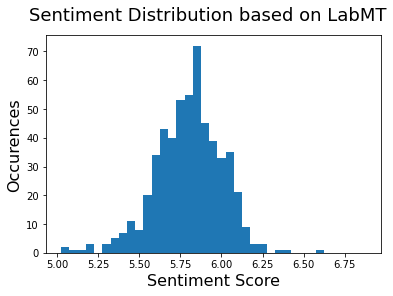

In [114]:
minimum=char_hap2[0][1]
maximum=char_hap2[-1][1]

char_labmt=[]

for i in range(len(char_hap)):
    char_labmt.append(char_hap[i][1])

b = np.array(np.arange(minimum,maximum+0.3,0.05))
hist,bins = np.histogram(char_labmt,b)
 
fig = plt.figure()
bar = plt.bar(b[:-1],hist,width=0.05)
fig.suptitle('Sentiment Distribution based on LabMT', fontsize=18)
plt.xlabel('Sentiment Score', fontsize=16)
plt.ylabel('Occurences', fontsize=16)
plt.show()

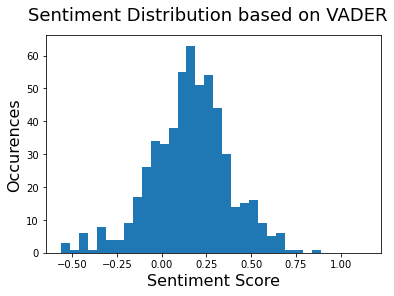

In [115]:
minimum=char_vad2[0][1]
maximum=char_vad2[-1][1]

char_vad3=[]

for i in range(len(char_vad)):
    char_vad3.append(char_vad[i][1])

b = np.array(np.arange(minimum,maximum+0.3,0.05))
hist,bins = np.histogram(char_vad3,b)
 
fig = plt.figure()
bar = plt.bar(b[:-1],hist,width=0.05)
fig.suptitle('Sentiment Distribution based on VADER', fontsize=18)
plt.xlabel('Sentiment Score', fontsize=16)
plt.ylabel('Occurences', fontsize=16)
plt.show()

This section allows us to identify the happiest and saddest aesthetics in the wiki. As expected, aesthetics related to fairy, bunnies, seasons, and colors stand out in both methods, however, for the VADRE method, the Romantic Goth appears as one of the happiest ones. Additionally, for the LabMT method stand out that 3 of the top 5 aesthetics are related to Girl and Mom.  

### Sentiment Analysis in communities using LabMT and VADER

In this section we calculate the average sentiment in the communities using the VADER and LabMT methods. 

First we start by reorganizing the two lists containing the scores VADER and LabMT scores, and the list with the aesthetics and communities in alfabethical order. This way we can join the name of the aesthetic, its community and scores into one list.

In [116]:
char_vad.sort(key = lambda x: x[0])
char_hap.sort(key = lambda x: x[0])
ch_1.sort(key = lambda x: x[0])

In [117]:
com_list=[]

dct_vad = dict((x, y) for x, y in char_vad)
dct_hap = dict((x, y) for x, y in char_hap)

for c in ch_1:
    char = c[0].replace(' ','_')
    char = char.replace('/','_')
    com_list.append((char,dct_hap[char],dct_vad[char],c[2]))

We order the list according to the communities.

In [118]:
com_list.sort(key = lambda x: x[3])

We calculate the average and standard deviation of each community and the count of individuals in them.

In [119]:
com_stats=[]

com_max=max(com_list,key=itemgetter(3))[3]

for i in range(com_max+1):
    count=0
    vad_community = []
    hap_community = []
    com_name=""
    
    for j in com_list:
        if j[3]==i:
            hap_community.append(j[1])
            vad_community.append(j[2])
            if count<=3:
                com_name+=str(j[0])+"-"
            count+=1
    com_name = com_name[:-1]
    if len(hap_community)<=1: # Statistic modelue uses the sample standard deviation formula and in communities with 1 element if fails because it devides by 0 (N-1)
                com_stats.append((com_name,statistics.mean(vad_community),0,
                              statistics.mean(hap_community),0,count))
    else:
        com_stats.append((com_name,statistics.mean(vad_community),statistics.stdev(vad_community),
                          statistics.mean(hap_community),statistics.stdev(hap_community),count))      

We can find the top 3 of highest and saddest communities by sorting the list from highest to lowest or reverse them to get the top and bottom for each method. 

In [120]:
VAD_sort_top=sorted(com_stats, key=itemgetter(1),reverse=True)
top3_VAD=VAD_sort_top[0:3]

print("The 3 happiest communities according to VADER are \n")
for w in range(3):
      print(top3_VAD[w][0],top3_VAD[w][1])

The 3 happiest communities according to VADER are 

Powwow_Step 0.46946666666666664
Emancicore 0.43437142857142863
Onii_Kei 0.42985


In [121]:
VAD_sort_bot=sorted(com_stats, key=itemgetter(1))
bot3_VAD=VAD_sort_bot[0:3]

print("The 3 saddest communities according to VADER are \n")
for w in range(3):
      print(bot3_VAD[w][0],bot3_VAD[w][1])

The 3 saddest communities according to VADER are 

Wandervogel -0.11960000000000001
Paninaro -0.085
Ero_guro -0.08026666666666667


In [122]:
labMT_sort_top=sorted(com_stats, key=itemgetter(3),reverse=True)
top3_labMT=labMT_sort_top[0:3]

print("The 3 happiest communities according to labMT are \n")

for w in range(3):
      print(top3_labMT[w][0],top3_labMT[w][3])

The 3 happiest communities according to labMT are 

Onii_Kei 6.104827586206896
Powwow_Step 6.0789189189189194
Bombacore 6.0733333333333315


In [123]:
labMT_sort_bot=sorted(com_stats, key=itemgetter(3))
bot3_labMT=labMT_sort_bot[0:3]
print("The 3 saddest communities according to labMT are \n")
for w in range(3):
      print(bot3_labMT[w][0],bot3_labMT[w][3])

The 3 saddest communities according to labMT are 

Sharpies 5.4515596330275224
Gorean 5.570967741935482
Wandervogel 5.586111111111111


For easy plotting and better organizing the data we summarize the data in a DataFrame.

In [124]:
df = pd.DataFrame(com_stats, columns =['Name', 'VADER','VADER_sd', 'LabMT','LabMT_sd','Total aesthetics'])
df

,Name,VADER,VADER_sd,LabMT,LabMT_sd,Total aesthetics
0,Abstract-Art_Academia-Art_Nouveau-Avant-garde,0.202683,0.222543,5.875664,0.207616,77
1,70s_Disco-Abstract_Tech-Acid_Pixie-Acidwave,0.208114,0.190430,5.857199,0.159107,83
2,Adventurecore-Agropeople-American_Pioneers-Ame...,0.237110,0.189284,5.890574,0.187146,79
3,Afro-Victorian,0.245540,0.000000,5.944037,0.000000,1
4,1950s_Suburbia-After_Hours-Anemoiacore-Angelcore,0.156801,0.259002,5.802034,0.186459,48
5,Alternative-Androgynous-Angura_Kei-Anti-Fashion,0.160561,0.214734,5.776241,0.181239,66
6,Anglocore,0.191989,0.000000,6.046949,0.000000,1
7,Animecore-Babycore-Babygirl-Bubble_Goth,0.223149,0.236150,5.854788,0.189691,68
8,Art_Deco-Atompunk-Cargopunk-Clockpunk,0.103503,0.235038,5.707077,0.234587,26
9,2_Tone-Athlete-Baddie-Barbiecore,0.130667,0.238919,5.745878,0.245865,70


We plot the average scores of the communities as a barplot with the standard deviation as the error bars.

<Figure size 432x288 with 0 Axes>

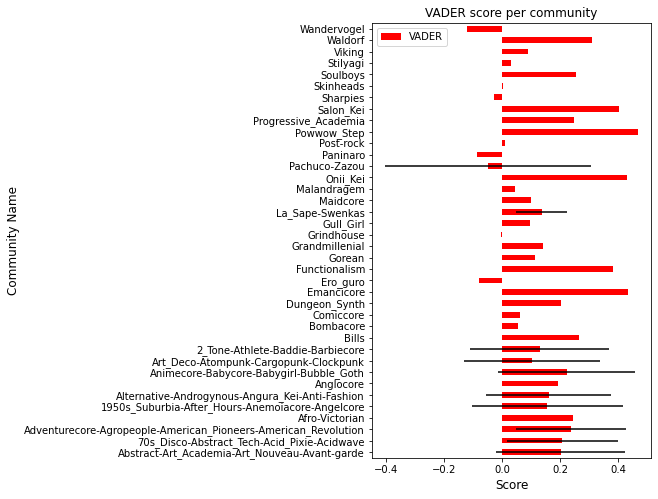

In [125]:
fig = plt.figure()
bar = df.plot(kind = "barh", y = "VADER", legend = True,
          x="Name",xerr="VADER_sd",
              title="VADER score per community", 
              color='red',figsize=(5,8))
plt.xlabel('Score', fontsize=12)
plt.ylabel('Community Name', fontsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

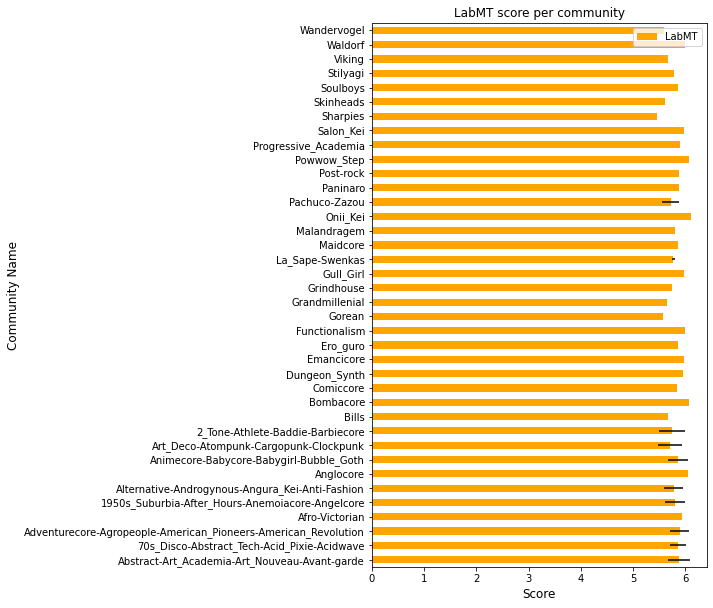

In [126]:
fig = plt.figure()
bar = df.plot(kind = "barh", y = "LabMT", legend = True,
          x="Name",xerr="LabMT_sd",title = "LabMT score per community", 
              color='orange',figsize=(6,10))
plt.xlabel('Score', fontsize=12)
plt.ylabel('Community Name', fontsize=12)
plt.show()


The outcome of this section is clear and provide insights on the communities. We were able to successfully calculate the average sentiment of the communities and visualize how they behave as a group. Additionally, we see that the average VADER scores present a more clear picture of the difference in sentiment among the communities than the LabMT.  

### Text Similarities

Analysis step 1
explain what you're interested in
explain the tool
apply the tool
discuss the outcome

In this section we assess the similarity between the description of each aesthetics. Our goal is to calculate the percentage of similarity between the texts and create a new network and link the aesthetics based on their text similarity.

We adapted the code and instructions in "An easy way to determine similarity between two strings of text using Python" (Tracyrenee, 2021). It can be reviewed in https://medium.com/geekculture/an-easy-way-to-determine-similarity-between-two-strings-of-text-using-python-de9b1b52f022

In [128]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize

similarities_total={}
sim_total=[]
used_aest=[]
super_sim=[]

#We load the content of each wiki page 
for file in DG:
    char_file=file.replace('/','_')
    char_file=char_file.replace(' ','_')
    similarities={}
    sim_list=[]
    with open ('sentiment/'+f'{char_file}.txt', 'r',encoding="utf-8") as f:
        my_text = f.read()
        
#We compare the content of one aesthetic with the content of all the aesthetics in the wiki.
    for file1 in DG:
        if file1 == file or file1 in used_aest:
            continue
        else:
            char_file1=file1.replace('/','_')
            char_file1=char_file1.replace(' ','_')
            text_words = []
            with open('sentiment/'+f'{char_file1}.txt', 'r',encoding="utf-8") as f:
                sk_text = f.read()

#Creating a corpus
            corpus = [my_text, sk_text]


#Converting the corpus to a matrix of TF-IDF features.
            from sklearn.feature_extraction.text import TfidfVectorizer

            vectorizer = TfidfVectorizer()
            trsfm=vectorizer.fit_transform(corpus)
            pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=['my_doc','sk_doc'])

#Calculate the cosine similarity of the vectors in the matrix
            from sklearn.metrics.pairwise import cosine_similarity
            percentage_of_similarity=round(cosine_similarity(trsfm[0:1], trsfm)[0][1]*100)
        
#Storing the results for later use
            sim_list.append((file1,percentage_of_similarity))
            super_sim.append((file,file1,percentage_of_similarity))
            similarities[file1]=percentage_of_similarity
    sim_list.sort(key=lambda x:x[1], reverse=True)
    used_aest.append(file)
    similarities_total[file]=similarities
    sim_total.append((file,sim_list))

We sort the list with all the similarities highest to lowest, and take the top 3301 elements. We use this number of elements to link the nodes of the new graph, the original network has 3301 edges. 

In [129]:
sorted_by_second = sorted(super_sim, key=lambda tup: tup[2], reverse=True)
new_edges=sorted_by_second[:3301]

We create a new graph woth all the aesthetics ans use the top 3301 percentages of similarities to create the edges.

In [140]:
g_new = nx.DiGraph()
g_new.add_nodes_from(similarities_total.keys())

In [141]:
for i in new_edges:
    g_new.add_edge(i[0], i[1], weight=i[2])

In [142]:
# Defining node colors and edge colors
d = dict(g_new.degree)
#mapping = {"Enemy": '#D22B2B', "Boss": '#FFD700', "Ally": '#63D1F4'}
colors = ["Green"]
edge_colors = ['Blue']

In [143]:
len(list(g_new.nodes()))

549

In [144]:
len(list(g_new.edges()))

3301

100%|██████████| 2000/2000 [00:24<00:00, 80.92it/s]


BarnesHut Approximation  took  3.52  seconds
Repulsion forces  took  18.74  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  1.23  seconds
AdjustSpeedAndApplyForces step  took  0.51  seconds


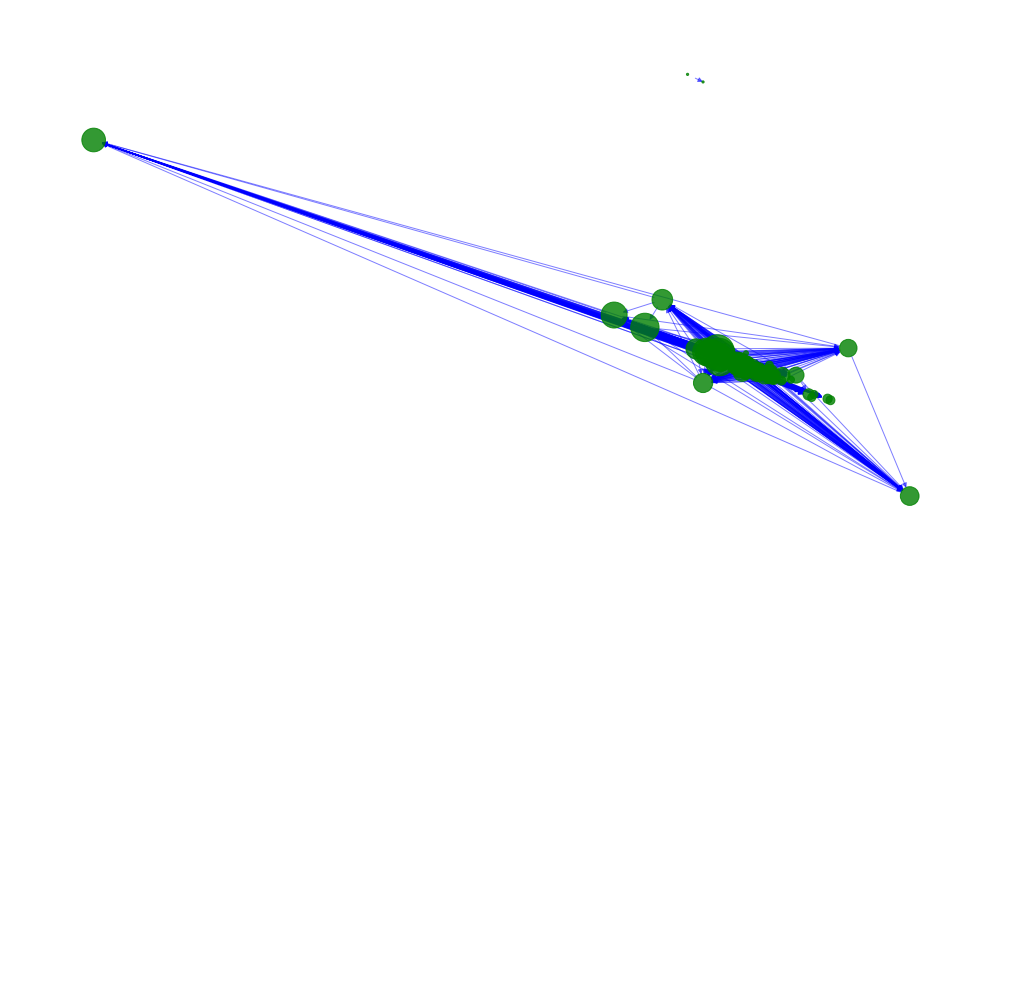

In [145]:
# Using force atlas configuration to achieve a pretty graph
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.5,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=40,

                        # Log
                        verbose=True)

plt.figure(figsize=(18,18)) 
positions = forceatlas2.forceatlas2_networkx_layout(g_new, pos=None, iterations=2000)
nx.draw_networkx_nodes(g_new, positions, node_size=[v*5 for v in list(d.values())], node_color=colors, alpha=0.8)
nx.draw_networkx_edges(g_new, positions, edge_color=edge_colors, alpha=0.5)
plt.axis('off')
plt.show()

In [146]:
sorted([
    {'name':x, 'value':g_new.in_degree(x)} 
    for x,y in g_new.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:20]

[{'name': 'Vaporwave', 'value': 150},
 {'name': 'Waif', 'value': 129},
 {'name': '1950s Suburbia', 'value': 112},
 {'name': 'Preppy', 'value': 101},
 {'name': 'Nymphet', 'value': 91},
 {'name': 'Milleniwave', 'value': 84},
 {'name': 'Trillwave', 'value': 80},
 {'name': 'Skinheads', 'value': 69},
 {'name': 'Y2K', 'value': 69},
 {'name': 'Southern Gothic', 'value': 62},
 {'name': 'Pop', 'value': 60},
 {'name': 'Roaring 20s', 'value': 60},
 {'name': 'Western', 'value': 59},
 {'name': 'Sloanies', 'value': 57},
 {'name': 'Synthwave', 'value': 55},
 {'name': 'Dark Academia', 'value': 52},
 {'name': 'Vintage Parisian', 'value': 47},
 {'name': 'Rollerwave', 'value': 43},
 {'name': 'Vampire', 'value': 43},
 {'name': 'Neo-Romanism', 'value': 42}]

In [151]:
sorted([
    {'name':x, 'value':g_new.out_degree(x)} 
    for x,y in g_new.nodes(data=True) 
], key=lambda k: k['value'],reverse=True)[0:20]

[{'name': 'Dark Academia', 'value': 181},
 {'name': 'Cottagecore', 'value': 178},
 {'name': 'Americana', 'value': 169},
 {'name': 'Bodikon', 'value': 105},
 {'name': 'Babygirl', 'value': 94},
 {'name': 'Afro-Victorian', 'value': 86},
 {'name': 'Afrofuturism', 'value': 83},
 {'name': 'Concore', 'value': 71},
 {'name': 'Golden Age of Detective Fiction', 'value': 68},
 {'name': 'Milleniwave', 'value': 66},
 {'name': 'American Pioneers', 'value': 65},
 {'name': 'Atompunk', 'value': 65},
 {'name': 'Heistcore', 'value': 56},
 {'name': 'Nymphet', 'value': 56},
 {'name': 'Fashwave', 'value': 55},
 {'name': 'Classicism', 'value': 52},
 {'name': 'Comiccore', 'value': 52},
 {'name': 'Fanfare', 'value': 48},
 {'name': 'Preppy', 'value': 48},
 {'name': 'Breakcore', 'value': 45}]

In [147]:
# extraction of GCC and creation of the undirected version of the graph
largest_cc = max(nx.weakly_connected_components(g_new), key=len)
DGCC = g_new.subgraph(largest_cc)
UGCC = DGCC.to_undirected()

In [148]:
len(DGCC.nodes()), len(DGCC.edges())

(266, 3300)

In [149]:
len(UGCC.nodes()), len(UGCC.edges())

(266, 3300)

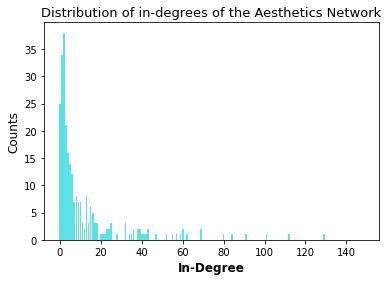

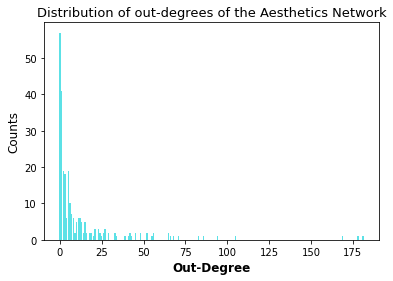

In [150]:
d_in=dict(DGCC.in_degree())
#Bar plot of the in-degree distribution
in_degrees=list(d_in.values())
v1 = np.arange(int(min(in_degrees)),int(max(in_degrees)))
count,bins=np.histogram(in_degrees,bins=v1)
plt.bar(bins[:-1], count,color='#5ce1e6')
plt.title('Distribution of in-degrees of the Aesthetics Network',fontsize=13)
plt.xlabel('In-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Counts',fontsize=12)
plt.show() 

d_out=dict(DGCC.out_degree())
#Bar plot of the out-degree distribution
out_degrees=list(d_out.values())
v2 = np.arange(int(min(out_degrees)),int(max(out_degrees))+2)
count,bins=np.histogram(out_degrees,bins=v2)
plt.bar(bins[:-1], count,color='#5ce1e6')
plt.title('Distribution of out-degrees of the Aesthetics Network',fontsize=13)
plt.xlabel('Out-Degree',fontsize=12,fontweight='bold')
plt.ylabel('Counts',fontsize=12)
plt.show() 

## 4. Discussion

### 4.1. Conclusions a.k.a. what went well?

* The very fact that the giant component is almost the whole graph gives us a hint that we can't look at aesthetics as completely separated from each other. Our analyses show that they are rather a spectrum and the different aesthetics intermingle. 
* As expected, the network based on text similarity, though having different number of nodes, has some similarities with the original network. Namely, the most connected elements are very similar in both cases.
* In the second network,  the number of nodes has reduced due to the applied definition of the connection. The network was to keep the original number of edges, so the average degree has increased in this case. This is in line with our conclusion about aesthetics being a spectrum
* The most important and useful outcome of our analyses are interactive networks that show summarized description of an aesthetic as the node attribute. This is an easy way of exploring the complex aesthetics dataset, and can be a nice way for everybody to discover something about the idea of beauty and how, and why it can be so different for different people.

### 4.2. What could be improved?

We are proud of the work we did, but we are aware that some things might be improved. We listed them below:
* The Aesthetics Wiki that we used, is users-created and of course the reach of this rather niche site is limited. In this case it might be valueable to combine the 
* Another thing is that aesthetics relate to different categories of art or beauty. The problem here is that: first, the categories in most cased overlap (not a problem impossible to overcome), and second, Fandom site that we used is not extremely well structured, so it was It would be nice to use some set theory stuff to categorize them

## 5. Contributions

All three of us were highly motivated and engaged in the work. Throughout the project, we tried to divide the work in a fair way and were discussing each element of the analyses. We've held numerous meeting and online calls to be aligned with the current progress.

For the part A of the assignment we divided the work in the following way. Bartek was responsible for the delivery of the video. Antek was performing the preliminary network analysis for the sake of the video. Gabo was researchnig and applying possible text analyses suitable for our problem.

For the part B, the main areas of responsibility were: graph analysis + visualisations (Bartek), sentiment analysis, text similarities and text-similarity based network + explatations (Gabo), preliminary text analysis, community detection, workclouds and website (Antek).

Though each area had its owner, we were still trying to help each other and discuss most of the steps of the analyses undertaken.